<a href="https://colab.research.google.com/github/rajprakrit/ML-Library-1/blob/master/Age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Drive Mount


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#PART I


In [2]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=297b2e5f782d491d8f7c25cc133e1fd657ebd8d173be2560c24ee0cbd23fd9a0
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [3]:
! pip install git+https://github.com/ildoonet/cutmix ##not useful for this data

  Cloning https://github.com/ildoonet/cutmix to /tmp/pip-req-build-28kw5ynj
  Running command git clone -q https://github.com/ildoonet/cutmix /tmp/pip-req-build-28kw5ynj
  Created wheel for cutmix: filename=cutmix-0.1-cp36-none-any.whl size=3602 sha256=63bc484d115beb053b54e805d6431803f492e36245bfc8e9cdea439cb7516d0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-d2kjxu1u/wheels/8a/40/20/615302921d0fef73e55b17b5dd57169d4879dfe6dd7ad8ff50
Successfully built cutmix


In [4]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=f2b81fa3de61e83def6d5178f781d4210c1d910eecdb63a54029b1ea0dad17c8
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [0]:
from __future__ import print_function, division
import os
import cv2
from PIL import Image
import pdb
import time
import copy
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip,VerticalFlip,RandomScale,CenterCrop, Rotate, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise,RandomRotate90,Transpose,RandomBrightnessContrast,RandomCrop)
from albumentations.pytorch import ToTensor
import albumentations as albu
import matplotlib.image as mpi
#import segmentation_models_pytorch as smp
from pathlib import Path
from sklearn.metrics import recall_score,f1_score
from sklearn.model_selection import StratifiedKFold
import gc
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
from efficientnet_pytorch import EfficientNet
# from cutmix.cutmix import CutMix
# from cutmix.utils import CutMixCrossEntropyLoss

In [6]:
model = EfficientNet.from_pretrained('efficientnet-b0',num_classes=3)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [0]:
#pretrainedmodels.model_names

In [0]:
#import pretrainedmodels
#model_name = 'resnet50' # could be fbresnet152 or inceptionresnetv2
#model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
for param in model.parameters():
    param.requires_grad_=False
#in_features = model.last_linear.in_features
#model.last_linear = nn.Linear(in_features,4)
#model.last_linear.requires_grad=True
model._fc.requires_grad=True

In [0]:
for param in model.parameters():
    param.requires_grad = True

#DATA LOADING AND SAMPLE

In [10]:
import pandas as pd
train = pd.read_csv('/content/drive/My Drive/Competitions/Analytics Vidya/Age Detection Of Actors/data/train.csv')
train.head(5)

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [11]:
train.columns

Index(['ID', 'Class'], dtype='object')

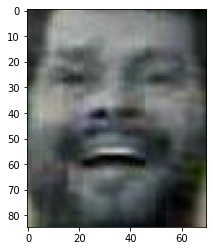

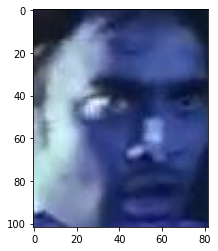

<Figure size 432x288 with 0 Axes>

In [13]:
for i in range(2):
  img = cv2.imread('/content/drive/My Drive/Competitions/Analytics Vidya/Age Detection Of Actors/data/Train/'+str(train.iloc[i,0]))
  # img = cv2.resize(img,(img.shape[1]*2,img.shape[0]*2))
  plt.imshow(img)
  plt.figure()

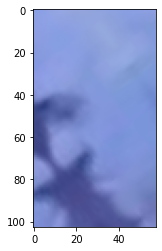

In [20]:
img = cv2.imread('/content/drive/My Drive/Competitions/Analytics Vidya/Age Detection Of Actors/data/Train/'+str(train.iloc[9,0]))
aug1 = Compose([GaussNoise(),
                  #  RandomBrightnessContrast(p=0.5),
                   VerticalFlip(p=0.4),
                   #RandomCrop(40,40,p=0.5),
                  #  CenterCrop(80,80,p=1),
                   HorizontalFlip(),
                   #ShiftScaleRotate(shift_limit=0.001, scale_limit=-1.22, rotate_limit=30, interpolation=2, border_mode=.1, p=1),
                   Rotate(limit=60,p=1)
                   ])(image=img)
img = aug1['image']
# img = cv2.resize(img, (128, 128))
plt.imshow(img)

In [21]:
train.Class.value_counts()

MIDDLE    10804
YOUNG      6706
OLD        2396
Name: Class, dtype: int64

#DATALOADER

In [0]:
class Dataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.transforms2 = get_transforms2(mean, std)
        self.fnames = self.df.index

    def __getitem__(self, idx):
        #print(self.df.columns)
        image_id = self.df["ID"].iloc[idx]
        image_path = os.path.join(self.root,  image_id)
        img = cv2.imread(image_path)
        img = cv2.resize(img,(128,128))
        
    
        label = np.asarray(self.df.iloc[idx].iloc[1:]).astype(np.uint8)
        

        augmented = self.transforms(image=img)
        img = augmented['image']
        
        return img,label

    def __len__(self):
        return len(self.fnames)



def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == 'train':
        list_transforms.extend(
                  [#GaussNoise(p=0.5),
                  #  RandomBrightnessContrast(p=0.5),
                   VerticalFlip(p=0.4),
                   #RandomCrop(40,40,p=0.5),
                  #  CenterCrop(40,30,p=0.5),
                   HorizontalFlip(),
                   #ShiftScaleRotate(shift_limit=0.001, scale_limit=-1.22, rotate_limit=30, interpolation=2, border_mode=.1, p=1),
                   Rotate(limit=45,p=.5)
                   ]
        )
    list_transforms.extend(
        [ 
            # Resize(128,128,interpolation = 2),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms
def get_transforms2( mean, std):
    list_transforms = []
    list_transforms.extend(
        [ 
            
            # Resize(128,128,interpolation = 2),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms
def crop_char_image3(image, threshold=80):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=0,
):
    '''Returns dataloader for the model training'''
    data = pd.read_csv(df_path)
    
    label = data['Class']
    data2 = pd.get_dummies(label)
   

    data=data.drop(columns=['Class'])
    data=pd.concat([data,data2],axis=1)

    train_df, val_df = train_test_split(data, test_size=0.95,stratify=label)
    df = train_df if phase == "train" else val_df
    image_dataset = Dataset(df, data_folder, mean, std, phase)
    
   
    
    dataloader = DataLoader(
        #dataset,
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=False,
        shuffle=True,   
    )
    return dataloader

In [0]:
bs = 16
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probs, t, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(t)
    with torch.no_grad():
        
        t = (t ).float().cpu()
        pt = probs.argmax(dim=1)
        tt = t.argmax(dim=1)
        
        csum = (pt==tt).sum().float()
        acc  = csum/batch_size
        f1_sc = f1_score(tt,pt,average='weighted')*100
        
    return acc,f1_sc

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.phase = phase
        self.accuracy = []
        self.f1 = []
       

    def update(self, targets, outputs):

        acc,f1_sc = metric(outputs, targets, self.base_threshold)
        self.accuracy.append(acc)
        self.f1.append(f1_sc)
        
    def get_metrics(self):
        acc = np.mean(self.accuracy)
        f1 = np.mean(self.f1)
        
        return acc,f1

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    acc,f1 = meter.get_metrics()
  
    print("Loss: %0.4f  | acc: %0.4f  | 100*f1_score: %0.4f " % (epoch_loss, acc, f1))
    
    return acc,f1
    

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


In [0]:
##Class weights
df = train
df.head()
x = df["Class"].value_counts()
class_wts = [0]*3
for i in range(len(x)):
    class_wts[i]=x.values[i]
maxi = max(class_wts)
for i in range(len(class_wts)):
    class_wts[i]=np.exp(-class_wts[i]/maxi)

In [0]:
class_wts = torch.Tensor(class_wts)

In [0]:
device = torch.device("cuda")
class_wts = class_wts.to(device)

In [0]:
 class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model,dataloader=None,lr=3e-3, epochs = 10):
        self.num_workers = 0
        self.batch_size = {"train": 16, "val": 16}
        self.accumulation_steps = 1
        self.lr = lr
        self.model_name = 'b0_aug.128X128'
        self.num_epochs = epochs
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model

        self.criterion = torch.nn.BCEWithLogitsLoss(weight=class_wts)
        
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        
        self.scheduler = ReduceLROnPlateau(self.optimizer,factor=0.33, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        

        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.acc_scores = {phase: [] for phase in self.phases}
        self.f1_scores = {phase: [] for phase in self.phases}

    def forward(self, images, targets):
        images = images.to(self.device)

        masks = targets.to(self.device)
        masks = masks.float()

        outputs = self.net(images)

        loss = self.criterion(outputs,masks)
       
        '''  after few epochs loss = "0.25*bce+0.75*dice"
        
        d1,d2,d3 = metric(outputs, mask, threshold=0.5, reduction='none')
        loss =  0.25*self.criterion(outputs.permute(0,2,3,1), masks.permute(0,2,3,1)) +0.75*(1-d1)
        
        '''

        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()

        for itr, batch in enumerate(tk0):
                
            img1, targets = batch

            loss, outputs = self.forward(img1, targets)
           
            
            loss = loss / self.accumulation_steps

            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches

        acc,f1 = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.acc_scores[phase].append(acc)
        self.f1_scores[phase].append(f1)

        torch.cuda.empty_cache()
        return epoch_loss
    def start2(self):
        for epoch in range(self.num_epochs):
            
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
    def start(self): 
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            
            if val_loss < self.best_loss:
                 print("******** New optimal found, saving state ********")
                 state["best_loss"] = self.best_loss = val_loss
            torch.save(state, "/content/drive/My Drive/Competitions/Analytics Vidya/Age Detection Of Actors/model/"+self.model_name+".pth")
            print()
            

In [0]:
train_df_path = '/content/drive/My Drive/Competitions/Analytics Vidya/Age Detection Of Actors/data/train.csv'
data_folder = "/content/drive/My Drive/Competitions/Analytics Vidya/Age Detection Of Actors/data/Train/"

In [0]:
device = torch.device("cuda")
model.to(device)

In [0]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

In [0]:
c=0
for params in model.parameters():
  c+=1
  if(c>=204) :
    params.requires_grad_=True
c

213

#Weight Loading

In [51]:
#load previous model
model = EfficientNet.from_pretrained('efficientnet-b0',num_classes=3)
ckpt_path = "/content/drive/My Drive/Competitions/Analytics Vidya/Age Detection Of Actors/model/b0_aug.128X128.pth"
device = torch.device("cuda")
model.to(device)
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"]) 

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

#Multiple Train Steps

In [52]:
model_trainer = Trainer(model,lr=0.0001, epochs = 1)   ###Only for acc
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 08:35:24



Loss: 0.0797  | acc: 0.9064  | 100*f1_score: 90.7860 
Starting epoch: 0 | phase: val | ⏰: 08:39:52



Loss: 0.0489  | acc: 0.9503  | 100*f1_score: 95.0682 
******** New optimal found, saving state ********



In [0]:
model_trainer = Trainer(model,lr=0.001, epochs = 10)
model_trainer.start()

In [0]:
model_trainer = Trainer(model,lr=0.001, epochs = 10)
model_trainer.start()

#MANUAL TRAIN N BABYSIT

In [0]:
#model_name = 'resnet18' # could be fbresnet152 or inceptionresnetv2
#model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
for param in model.parameters():
   #param.requires_grad = True
   print(param.requires_grad)
#in_features = model.last_linear.in_features
#model.last_linear = nn.Linear(in_features,4)
#model.last_linear.requires_grad = True
#model.to(device)

In [0]:
model_trainer = Trainer(model,lr=3e-3)
model_trainer.start()

TypeError: ignored

#K-FOLD(NOT USED)

In [0]:
from sklearn.model_selection import StratifiedKFold
k = 4
df_path = '/content/drive/My Drive/Competitions/Analytics Vidya/Age Detection Of Actors/data/test.csv'
data = pd.read_csv(df_path)
skf = StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
t = data.Class
dataloader = []

for train_index, test_index in skf.split(np.zeros(len(t)), t):
    #print(train_index,test_index)
    train_df = data.loc[train_index]
    val_df = data.loc[test_index]
    #print(train_df.shape,val_df.shape)
    dicti = {}
    for phase in ['train','val'] :
      df = train_df if phase == "train" else val_df
      label = df['Class']
      data2 = pd.get_dummies(label)
      df=df.drop(columns=['Class'])
      df=pd.concat([df,data2],axis=1)
      dataset = Dataset(df, data_folder, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), phase=phase )
      dicti[phase]= DataLoader(
                dataset,
                batch_size=16,
                num_workers=0,
                pin_memory=False,
                shuffle=True,   
                )
    dataloader.append(dicti)
dataloader

[{'train': <torch.utils.data.dataloader.DataLoader at 0x7f01fa2b6780>,
  'val': <torch.utils.data.dataloader.DataLoader at 0x7f01fa2b6cc0>},
 {'train': <torch.utils.data.dataloader.DataLoader at 0x7f01fa2b6fd0>,
  'val': <torch.utils.data.dataloader.DataLoader at 0x7f01fa2b66a0>},
 {'train': <torch.utils.data.dataloader.DataLoader at 0x7f01fa276be0>,
  'val': <torch.utils.data.dataloader.DataLoader at 0x7f01f00810b8>},
 {'train': <torch.utils.data.dataloader.DataLoader at 0x7f01f0081668>,
  'val': <torch.utils.data.dataloader.DataLoader at 0x7f01f0081a58>}]

In [0]:
len(dataloader)

4

In [0]:
resnet18_models = []
device = torch.device("cuda")
for iterator in range(k):
     print("Fold : ",iterator)
     model_name = 'resnet18' # could be fbresnet152 or inceptionresnetv2
     model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
     #for param in model.parameters():
     #   param.requires_grad = False
     in_features = model.last_linear.in_features
     model.last_linear = nn.Linear(in_features,4)
     model.last_linear.requires_grad = True
     model.to(device)
     model_trainer = Trainer(model,dataloader[iterator])
     model_trainer.start()
     resnet18_models.append(model)

#PREDICTION

##TEST DATALOADER


In [0]:
class TestDataset(Dataset):
    def __init__(self, df, data_folder, mean, std):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.transforms = get_transforms_test(mean, std)
        self.transforms2 = get_transforms2_test(mean, std)
        self.fnames = self.df.index

    def __getitem__(self, idx):
        #print(self.df.columns)
        image_id = self.df["Image"].iloc[idx]
        image_path = os.path.join(self.root,  image_id)
        img = cv2.imread(image_path)
        
        img = cv2.resize(img, (128, 128))

        img1 = augmented['image']    
        augmented = self.transforms(image=img)
        # img2 = augmented['image']    
        # augmented = self.transforms(image=img)
        # img3 = augmented['image']    
        # augmented = self.transforms(image=img)
        # img4 = augmented['image']    
        # augmented = self.transforms(image=img)
        # img5 = augmented['image']    
        # augmented = self.transforms(image=img)
        # img6 = augmented['image']    
        # augmented = self.transforms(image=img)
        # img7 = augmented['image']    
        # augmented = self.transforms(image=img)
        # img8 = augmented['image']    
        # augmented = self.transforms(image=img)
        # img9 = augmented['image']
        #imag2 = imag2.reshape(imag2.shape[0],imag2.shape[1],1)
        #imag2 = np.concatenate([imag2,imag2,imag2],axis=2)
        #aug = self.transforms(image=imag2)
        #imagtf1 = aug['image']
        #aug = self.transforms2(image = imag2)
        #imagtf2 = aug["image"]
        return img1

    def __len__(self):
        return len(self.fnames)


def get_transforms_test(mean, std):
    list_transforms = []
    # list_transforms.extend(
    #         [#GaussNoise(p=0.5),
    #                 RandomBrightnessContrast(p=0.5),
    #                 VerticalFlip(p=0.4),
    # #                #RandomCrop(40,40,p=0.5),
    # #                #CenterCrop(40,40,p=0.4),
    #                 HorizontalFlip(),
    # #                #ShiftScaleRotate(shift_limit=0.001, scale_limit=-1.22, rotate_limit=30, interpolation=2, border_mode=.1, p=1),
    #                 Rotate(limit=30,p=.5)
    #             ]
    #      )
    list_transforms.extend(
        [ 
            # Resize(128,128,interpolation = 2),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms
def get_transforms2_test( mean, std):
    list_transforms = []
    list_transforms.extend(
        [ 
            
            Resize(128,128,interpolation = 2),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms
def crop_char_image3(image, threshold=80):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def providerx(
    data_folder,
    df_path,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=0,
):
    '''Returns dataloader for the model training'''
    data = pd.read_csv(df_path)
    #label = data['grapheme_root']
    #label3 = data['consonant_diacritic']
    #label2 = data['vowel_diacritic']
    #label = data['grapheme_root']
    #label = data['Class']
    #data2 = pd.get_dummies(label)
    #data3 = pd.get_dummies(label2)
    #data4 =  pd.get_dummies(label3)
    # dict={}
    # for i in range(168):
    #     dict[(i)] = i+1
    # data2.rename(columns=dict,inplace=True)    
    # dict2 = {}
    # for i in range(11):
    #     dict2[(i)] = i+169
    # data3.rename(columns=dict2,inplace=True)    
    # dict3= {}
    # for i in range(7):
    #     dict3[(i)] = i+180
    # data4.rename(columns=dict3,inplace=True)
    
    #data=data.drop(columns=['grapheme_root','vowel_diacritic','consonant_diacritic','grapheme'])
    #data=pd.concat([data,data2,data3,data4],axis=1)

    #data=data.drop(columns=['Class'])
    #data=pd.concat([data,data2],axis=1)

    #train_df, val_df = train_test_split(data, test_size=0.2,stratify=label)
    #df = train_df if phase == "train" else val_df
    test_image_dataset = TestDataset(data, data_folder, mean, std)
    
    #class_sample_counts=np.unique(label, return_counts=True)[1]
   # weights = (1 / torch.Tensor(class_prob))
   # weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(train_labels))
    #train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=weighted_sampler)
    
    #dataset = CutMix(image_dataset, num_class=186, beta=1.0, prob=0.5, num_mix=2)
    
    dataloader = DataLoader(
        #dataset,
        test_image_dataset,
        batch_size=batch_size,
        shuffle=False,   
    )
    return dataloader 

##Without TTA

In [43]:
#only resize
test_data_folder = "/content/drive/My Drive/Competitions/Analytics Vidya/Age Detection Of Actors/data/Test"
test_df_path = "/content/drive/My Drive/Competitions/Analytics Vidya/Age Detection Of Actors/data/test.csv"
data_type = 'test'

batch_size = 16

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

test_preds_list = []

row_id = []
target = []

test_loader = providerx(test_data_folder, test_df_path, mean=mean, std=std, batch_size=16, num_workers=0)


# p0=np.zeros((3219,))
x=[]

for  i,batch in enumerate(tqdm((test_loader))):
  
  # Class = []
  img = batch
  
  bp  = model(img.to(device)).detach().cpu().numpy()

  print(bp)
  
  # Class.extend(np.argmax(bp,axis=1))
  x.extend(bp)
  
  # test_preds_list.append([Class])
  
# p0 = np.concatenate([test_preds[0] for test_preds in test_preds_list], axis=0)
gc.collect()

KeyError: ignored

#PART II

In [0]:
test_df = pd.read_csv('/content/drive/My Drive/Competitions/Analytics Vidya/Age Detection Of Actors/data/test.csv')

In [0]:
#p0 = np.concatenate([test_preds[0] for test_preds in test_preds_list], axis=0)
dicti = {0:"MIDDLE",1:"OLD",2:"YOUNG"}
p1 = [dicti[i] for i in p0]
#print('concat:', 'p0', p0.shape)
submission_df = pd.DataFrame({'Class': p1,'ID':test_df["ID"] })
submission_df.to_csv('submission.csv', index=False)

In [0]:
sub_df = pd.read_csv('/content/submission.csv')

In [0]:
sub_df.head(5)

,Class,Image
0,OLD,25321.jpg
1,OLD,989.jpg
2,OLD,19277.jpg
3,OLD,13093.jpg
4,OLD,5367.jpg


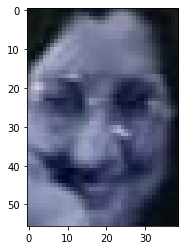

In [0]:
im = cv2.imread('/content/drive/My Drive/Competitions/Analytics Vidya/Age Detection Of Actors/data/Test/25321.jpg')
plt.imshow(im)

In [0]:
p1 = np.load('/content/subSqueeze128 (1).npy')

In [0]:
p4 = p0

In [0]:
df = pd.read_csv('/content/submission (35).csv')
dicti = {"Attire":0,"Decorationandsignage":1,"Food":2,"misc":3}
p2 = [dicti[i] for i in df.Class]

In [0]:
p1 = np.argmax(p1,axis=1)
p1

array([2, 2, 2, ..., 3, 3, 3])

In [0]:
p3 = (p1+p4)//2

In [0]:
p1

array([[0.06443055, 0.06806318, 0.6754856 , 0.19202071],
       [0.10136419, 0.2698184 , 0.43284553, 0.19597194],
       [0.1592902 , 0.00552815, 0.76382697, 0.07135467],
       ...,
       [0.44178262, 0.00085357, 0.00827961, 0.54908425],
       [0.08948147, 0.08838122, 0.06850307, 0.75363433],
       [0.05396221, 0.05550498, 0.04835311, 0.84217966]], dtype=float32)

In [0]:
x = np.array(x)

In [0]:
x.shape

(3219, 4)

In [0]:
np.save("b0_aug_80.09.npy",x)

In [0]:
x1 = np.load('/content/b0_aug_80.09.npy')
x2 = np.load('/content/b2_aug_81.45.npy')
x3 = np.load('/content/subres2nxt.npy')
x4 = np.load('/content/subresnet34.npy')
x5 = np.load('/content/subeffb2a (1).npy')

In [0]:
x = x1+x2+x3+x4+x5

In [0]:

x = np.argmax(x,axis=1)

In [0]:
p0 = x

In [0]:
x1 = np.argmax(x1,axis=1)
x2 = np.argmax(x2,axis=1)
x3 = np.argmax(x3,axis=1)
x4 = np.argmax(x4,axis=1)
x5 = np.argmax(x5,axis=1)
x = np.concatenate([x1,x2,x3,x4,x5],axis=0).reshape(3219,5)

AxisError: ignored

In [0]:
x1[:20]

array([[ -58.798798 , -143.1228   ,   45.03953  ,  -60.30361  ],
       [ -29.280483 ,  -75.66561  ,   12.6686735,  -17.002186 ],
       [ -93.18239  ,  -80.71849  ,   48.4285   ,  -69.959045 ],
       [-137.09775  ,  -91.53788  ,   73.97832  ,  -81.840645 ],
       [  85.639755 , -130.44252  , -101.11647  , -131.27252  ],
       [  37.692482 , -102.7865   ,  -55.269417 ,  -40.800434 ],
       [ -31.541021 ,   51.655914 ,  -98.97576  ,  -86.583984 ],
       [ -36.342064 ,  -94.44689  ,  -58.41116  ,   32.450886 ],
       [ -72.71012  , -113.19932  ,  -76.77874  ,   57.087452 ],
       [  51.52657  ,  -59.0407   ,  -76.68013  ,  -75.49793  ],
       [ -33.037586 ,   30.993378 ,  -60.191135 ,  -36.346474 ],
       [-104.25332  ,   72.36039  ,  -77.48072  ,  -76.34919  ],
       [ -45.814087 ,  -29.273264 ,   -8.201518 ,  -17.098682 ],
       [ -62.707253 ,  -23.543945 ,  -43.754654 ,   19.941654 ],
       [ -94.88005  ,  -79.175354 ,   63.302185 ,  -74.085915 ],
       [ -79.11742  , -13

In [0]:
x2[:20]

array([[-55.73487  , -68.12797  ,  45.740158 , -58.25296  ],
       [-31.137566 , -28.331581 ,  11.146493 ,  -6.611107 ],
       [-33.108307 , -43.734974 ,   7.459674 , -11.400465 ],
       [-52.681725 , -61.384766 ,  49.439507 , -54.568848 ],
       [ 27.788414 , -45.122974 , -25.124245 , -32.248203 ],
       [ 33.27888  , -72.16063  , -51.295116 , -35.491127 ],
       [ -7.697331 ,   4.893741 , -45.02973  , -23.217188 ],
       [-14.763268 , -12.666718 , -20.654018 ,   5.650837 ],
       [-48.682648 , -58.002953 , -47.86395  ,  44.51071  ],
       [ 21.331951 , -36.54025  , -34.94999  , -20.496416 ],
       [-18.698208 ,  16.218681 , -26.626686 , -13.387829 ],
       [-39.58984  ,  48.06991  , -44.71605  , -48.661118 ],
       [-32.42987  , -17.324856 ,  -8.766498 ,   2.6055984],
       [-35.63124  , -26.111677 , -16.236908 ,  12.043753 ],
       [-40.377815 , -34.19481  ,  23.577679 , -24.161728 ],
       [-48.03213  , -54.8958   ,  27.238113 , -23.184685 ],
       [ 24.213419 , -40

In [0]:
x3[:20]

array([2, 2, 2, 2, 0, 0, 0, 3, 3, 0, 3, 1, 3, 3, 2, 2, 0, 2, 3, 0])

In [0]:
x4[:20]

array([2, 3, 2, 2, 0, 0, 3, 0, 3, 0, 3, 1, 1, 1, 2, 2, 0, 2, 3, 0])

In [0]:
x5[:20]

array([2, 3, 2, 2, 0, 0, 0, 1, 3, 0, 3, 1, 3, 1, 2, 2, 0, 2, 3, 0])

In [0]:
x[0]

array([4611686018427387904, 4611686018427387904, 4611686018427387904,
       4611686018427387904, 4611686018427387904])

In [0]:
x

array([[4611686018427387904, 4611686018427387904, 4611686018427387904,
        4611686018427387904, 4611686018427387904],
       [4611686018427387904, 4611686018427387904, 4611686018427387904,
        4613937818241073152, 4613937818241073152],
       [4611686018427387904, 4611686018427387904, 4611686018427387904,
        4611686018427387904, 4611686018427387904],
       ...,
       [4613937818241073152, 4613937818241073152, 4613937818241073152,
        4613937818241073152, 4613937818241073152],
       [4613937818241073152, 4613937818241073152, 4613937818241073152,
        4613937818241073152, 4613937818241073152],
       [4613937818241073152, 4613937818241073152, 4613937818241073152,
        4613937818241073152, 4613937818241073152]])